In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'

import pandas as pd
import swifter
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [2]:
np.random.seed(5)
tf.random.set_seed(5)

In [3]:
df = pd.read_json("dataPhishingDetection.json")

In [4]:
df

,_id,user,nombre,apellido,profesion,carrera,email,genero,inEdad,anioExperiencia,...,Ejercicio_5,Ejercicio_6,Ejercicio_7,Ejercicio_8,Ejercicio_9,Ejercicio_10,Resultados,Ejercicio_99,IP,FechaInicio
0,{'$oid': '605c0b72368efe27b3457db2'},GtDave,Dave,Gt,Profesional,Ingeniería Electrónica,dave@live.com,Masculino,38,10,...,"{'coordenadas': [['0', '0', '1.48'], ['0', '0'...","{'coordenadas': [['0', '0', '1.48'], ['0', '0'...","{'coordenadas': [['0', '0', '1.48'], ['0', '0'...","{'coordenadas': [['0', '0', '1.48'], ['0', '0'...","{'coordenadas': [['0', '0', '1.47'], ['0', '0'...","{'coordenadas': [['0', '0', '1.44'], ['0', '0'...","{'tiempoTotal': '484.21', 'tiempoPromedio': '8...",NaN,NaN,NaN
1,{'$oid': '605c96189b6e2d00be7d1552'},NarvaezEdwin,Edwin,Narvaez,Profesional,Ingeniería Electrónica,armandwined@yahoo.es,Femenino,45,6,...,"{'coordenadas': [['816', '434', '1.45'], ['516...","{'coordenadas': [['843', '465', '1.47'], ['891...","{'coordenadas': [['743', '383', '1.47'], ['728...","{'coordenadas': [['745', '437', '1.42'], ['804...","{'coordenadas': [['816', '338', '1.47'], ['773...","{'coordenadas': [['725', '367', '1.46'], ['725...","{'tiempoTotal': '307.93', 'tiempoPromedio': '5...",NaN,NaN,NaN
2,{'$oid': '605c991c98e8a66433397d52'},ContrerasMari,Mari,Contreras,Profesional,Ingeniería Software,maricontreras@hotmail.ec,Femenino,19,3,...,"{'coordenadas': [['0', '0', '1.47'], ['0', '0'...","{'coordenadas': [['0', '0', '1.47'], ['0', '0'...","{'coordenadas': [['0', '0', '1.47'], ['0', '0'...","{'coordenadas': [['0', '0', '1.47'], ['0', '0'...","{'coordenadas': [['0', '0', '1.47'], ['0', '0'...","{'coordenadas': [['0', '0', '1.46'], ['0', '0'...","{'tiempoTotal': '430.19', 'tiempoPromedio': '7...",NaN,NaN,NaN
3,{'$oid': '605c9bd61ad9d83967747c02'},RodríguezVictoria,Victoria,Rodríguez,Profesional,Ingeniería Software,viviro3636@gmail.com,Femenino,43,0,...,"{'coordenadas': [['953', '199', '1.47'], ['949...","{'coordenadas': [['646', '233', '1.48'], ['646...","{'coordenadas': [['709', '288', '1.48'], ['793...","{'coordenadas': [['745', '374', '1.48'], ['855...","{'coordenadas': [['898', '385', '1.48'], ['828...","{'coordenadas': [['844', '226', '1.49'], ['796...","{'tiempoTotal': '451.28', 'tiempoPromedio': '7...",NaN,NaN,NaN
4,{'$oid': '605c9c8ff00dc06c747aed82'},CuevasPepe,Pepe,Cuevas,Estudiante,Ingeniería Sistemas,pcuevas@gmail.com,Masculino,25,1,...,"{'coordenadas': [['0', '0', '1.45'], ['0', '0'...","{'coordenadas': [['0', '0', '1.46'], ['0', '0'...","{'coordenadas': [['0', '0', '1.45']], 'focus':...","{'coordenadas': [['0', '0', '1.45'], ['0', '0'...","{'coordenadas': [['0', '0', '1.45'], ['0', '0'...","{'coordenadas': [['0', '0', '1.45'], ['0', '0'...","{'tiempoTotal': '94.49', 'tiempoPromedio': '15...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,{'$oid': '605d1b497a414f26270f5e72'},Galarza CruzChristian,Christian,Galarza Cruz,Estudiante,Ingeniería Electrónica,crgalarza1@espe.edu.ec,Masculino,24,1,...,"{'coordenadas': [['728', '270', '1.48'], ['817...","{'coordenadas': [['855', '242', '1.47'], ['700...","{'coordenadas': [['792', '301', '1.49'], ['680...","{'coordenadas': [['790', '256', '1.47'], ['776...","{'coordenadas': [['763', '272', '1.47'], ['941...","{'coordenadas': [['588', '394', '1.47'], ['532...","{'tiempoTotal': '245.52', 'tiempoPromedio': '4...",NaN,157.100.172.172,"{'0': 1616714568, 'seconds': 48, 'minutes': 22..."
61,{'$oid': '605d1d345798f653e168bee2'},MontalvoViviana,Viviana,Montalvo,Profesional,Ingeniería Electrónica,viviana_montalvo@ieee.org,Femenino,26,0,...,"{'coordenadas': [['0', '0', '1.45'], ['874', '...","{'coordenadas': [['971', '353', '1.45'], ['971...","{'coordenadas': [['0', '0', '1.45'], ['1096', ...","{'coordenadas': [['617', '0', '2.06'], ['617',...","{'coordenadas': [['934', '296', '1.46'], ['921...","{'coordenadas': [['905', '355', '1.46'], ['909...","{'tiempoTotal': '546.37', 'tiempoPromedio': '9...",NaN,181.112.83.111,"{'0': 1616715059, 's

In [5]:
df_new = pd.DataFrame(df.iloc[:,10:20])

In [6]:
final_df = list()
for column in df_new.columns:
    final_df.append(df_new[column].swifter.progress_bar(False).apply(pd.Series))

In [7]:
df_full = final_df[0]
for df in final_df[1:]:
    df_full = df_full.append(df)

In [8]:
df_full = df_full.drop(columns=[0]).dropna()

In [9]:
df_full.focus[df_full.focus == 99] = None
df_full.click[df_full.click == 99] = None

In [10]:
df_full = df_full.reset_index(drop=True)

In [11]:
df_click = df_full.click.swifter.progress_bar(False).apply(pd.Series)
columns = df_click.columns
new_list = list()
for column in columns:
    test_df = df_click[column].swifter.progress_bar(False).apply(pd.Series)
    test_df.columns = ['click_place_'+str(column),'click_time_'+str(column)]
    new_list.append(test_df)
    
df_click = pd.concat(new_list,axis=1)

In [12]:
df_coor = df_full.coordenadas.swifter.progress_bar(False).apply(pd.Series)

columns = df_coor.columns
new_list = list()
for column in columns:
    test_df = df_coor[column].swifter.progress_bar(False).apply(pd.Series)
    test_df.columns = ['coor_x_'+str(column),'coor_y_'+str(column),'coor_z_'+str(column)]
    new_list.append(test_df)
    
df_coor = pd.concat(new_list,axis=1)

In [13]:
df_focus = df_full.focus.swifter.progress_bar(False).apply(pd.Series)
columns = df_focus.columns
new_list = list()
for column in columns:
    test_df = df_focus[column].swifter.progress_bar(False).apply(pd.Series)
    test_df.columns = ['focus_place_'+str(column),'focus_time_'+str(column)]
    new_list.append(test_df)
    
df_focus = pd.concat(new_list,axis=1)

In [14]:
df_resp = pd.DataFrame(df_full.respuesta)
df_resp[df_resp == '[1,"Phishing"]'] = 1
df_resp[df_resp == '[0,"Phishing"]'] = 0
df_resp[df_resp == '[1,"Legitimo"]'] = 0
df_resp[df_resp == '[0,"Legitimo"]'] = 1

df_resp = df_resp.astype(int)

In [15]:
df_click = df_click.fillna(0)
df_coor = df_coor.fillna(0)
df_focus = df_focus.fillna(0)

In [16]:
encoder_click = TargetEncoder()
encoder_focus = TargetEncoder()

In [17]:
df_click.iloc[:,::2] = encoder_click.fit_transform(df_click.iloc[:,::2],df_resp)
df_focus.iloc[:,::2] = encoder_focus.fit_transform(df_focus.iloc[:,::2],df_resp)

In [18]:
EMBEDDING_DIM = 100

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_full.comentario.str.lower().values)
word_index = tokenizer.word_index

In [19]:
len(tokenizer.word_counts)

1274

In [20]:
df_com = tokenizer.texts_to_sequences(df_full.comentario.str.lower().values)
df_com = pad_sequences(df_com)

Comentario

In [21]:
inputs_com = keras.Input(shape=(df_com.shape[1],),name="comentario")
emb_com = keras.layers.Embedding(1275, EMBEDDING_DIM, input_shape=(df_com.shape[1],),name="embedding")
x_com = emb_com(inputs_com)
spDrop_com = keras.layers.SpatialDropout1D(0.2)
x_com = spDrop_com(x_com)
lstm_com = keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2)
x_com = lstm_com(x_com)
dense_com = keras.layers.Dense(12, activation='sigmoid', name="comentario_out")
x_com = dense_com(x_com)

Click

In [22]:
inputs_click = keras.Input(df_click.iloc[:,::2].shape[1],name="click")
dense_click1 = keras.layers.Dense(100, activation='relu')
drop_click = keras.layers.Dropout(0.2)
dense_click2 = keras.layers.Dense(6, activation='sigmoid')
x_click = dense_click1(inputs_click)
x_click = drop_click(x_click)
x_click = dense_click2(x_click)

In [23]:
inputs_clickt = keras.Input(df_click.iloc[:,1::2].shape[1],name="click_tiempo")
dense_clickt1 = keras.layers.Dense(100, activation='relu')
drop_clickt = keras.layers.Dropout(0.2)
dense_clickt2 = keras.layers.Dense(6, activation='sigmoid')
x_clickt = dense_clickt1(inputs_clickt)
x_clickt = drop_clickt(x_clickt)
x_clickt = dense_clickt2(x_clickt)

In [24]:
concat_click = keras.layers.Concatenate(name="click_out")
x_click = concat_click([x_click,x_clickt])

Coordenadas

In [25]:
inputs_coor = keras.Input(df_coor.shape[1],name="coordenadas")
dense_coor1 = keras.layers.Dense(100,activation='relu')
drop_coor = keras.layers.Dropout(0.2)
dense_coor2 = keras.layers.Dense(12,activation='sigmoid',name="coordenadas_out")
x_coor = dense_coor1(inputs_coor)
x_coor = drop_coor(x_coor)
x_coor = dense_coor2(x_coor)

Focus

In [26]:
inputs_focus = keras.Input(df_focus.iloc[:,::2].shape[1],name="focus")
dense_focus1 = keras.layers.Dense(100, activation='relu')
drop_focus = keras.layers.Dropout(0.2)
dense_focus2 = keras.layers.Dense(6, activation='sigmoid')
x_focus= dense_focus1(inputs_focus)
x_focus= drop_focus(x_focus)
x_focus = dense_focus2(x_focus)

In [27]:
inputs_focust = keras.Input(df_focus.iloc[:,1::2].shape[1],name="focus_tiempo")
dense_focust1 = keras.layers.Dense(100, activation='relu')
drop_focust = keras.layers.Dropout(0.2)
dense_focust2 = keras.layers.Dense(6, activation='sigmoid')
x_focust = dense_focust1(inputs_focust)
x_focust = drop_focust(x_focust)
x_focust = dense_focust2(x_focust)

In [28]:
concat_focus = keras.layers.Concatenate(name="focus_out")
x_focus= concat_focus([x_focus,x_focust])

Tiempo

In [29]:
inputs_tiempo = keras.Input(1,name="tiempo")
dense_tiempo1 = keras.layers.Dense(100, activation='relu')
drop_tiempo = keras.layers.Dropout(0.2)
dense_tiempo2 = keras.layers.Dense(12, activation='sigmoid',name="tiempo_out")
x_tiempo = dense_tiempo1(inputs_tiempo)
x_tiempo = drop_tiempo(x_tiempo)
x_tiempo = dense_tiempo2(x_tiempo)

Modelo

In [30]:
concat = keras.layers.Concatenate()
x = concat([x_com,x_click,x_coor,x_focus,x_tiempo])
dense1 = keras.layers.Dense(100, activation='relu')
drop = keras.layers.Dropout(0.2)
dense2 = keras.layers.Dense(1, activation='sigmoid')
x = dense1(x)
x = drop(x)
x = dense2(x)

In [31]:
model = keras.Model(
    inputs=[inputs_com,inputs_click,inputs_clickt,inputs_coor,inputs_focus,inputs_focust,inputs_tiempo],
    outputs=x)
model.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])

In [32]:
df_resp = df_resp.astype('float64')
df_com = df_com.astype('float64')
df_click = df_click.astype('float64')
df_focus = df_focus.astype('float64')
df_coor = df_coor.astype('float64')
df_tiempo = df_full.tiempo.astype('float64')

In [33]:
model.fit(
    {"comentario":df_com,
     "click":df_click.iloc[:,::2],
     "click_tiempo":df_click.iloc[:,1::2],
     "coordenadas":df_coor,
     "focus":df_focus.iloc[:,::2],
     "focus_tiempo":df_focus.iloc[:,1::2],
     "tiempo":df_tiempo},
    df_resp,
    epochs=1000,
    batch_size=2048,
    #verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=100, min_delta=0.0001)]
)

Epoch 1/1000
1/1 [==============================] - 15s 15s/step - loss: 0.2505 - accuracy: 0.5154
Epoch 2/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2432 - accuracy: 0.5880
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2403 - accuracy: 0.5941
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2383 - accuracy: 0.6111
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 0.2401 - accuracy: 0.6065
Epoch 6/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2382 - accuracy: 0.6019
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2361 - accuracy: 0.5972
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2376 - accuracy: 0.6019
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2383 - accuracy: 0.6096
Epoch 10/1000
1/1 [==============================] - 2s 2s/step - loss: 0.2408 - accuracy: 0.6065
Epoch 11/1000
1/1 [========

1/1 [==============================] - 3s 3s/step - loss: 0.0261 - accuracy: 0.9676
Epoch 85/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0259 - accuracy: 0.9599
Epoch 86/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0254 - accuracy: 0.9614
Epoch 87/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0265 - accuracy: 0.9583
Epoch 88/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0256 - accuracy: 0.9676
Epoch 89/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0249 - accuracy: 0.9660
Epoch 90/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0232 - accuracy: 0.9738
Epoch 91/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0224 - accuracy: 0.9707
Epoch 92/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0237 - accuracy: 0.9707
Epoch 93/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0243 - accuracy: 0.9645
Epoch 94/1000
1/1 [===============

1/1 [==============================] - 4s 4s/step - loss: 0.0167 - accuracy: 0.9753
Epoch 168/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0168 - accuracy: 0.9799
Epoch 169/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0161 - accuracy: 0.9769
Epoch 170/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0167 - accuracy: 0.9769
Epoch 171/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0156 - accuracy: 0.9815
Epoch 172/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0165 - accuracy: 0.9769
Epoch 173/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0152 - accuracy: 0.9815
Epoch 174/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0161 - accuracy: 0.9830
Epoch 175/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0149 - accuracy: 0.9830
Epoch 176/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0155 - accuracy: 0.9769
Epoch 177/1000
1/1 [=====

1/1 [==============================] - 4s 4s/step - loss: 0.0120 - accuracy: 0.9892
Epoch 250/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0135 - accuracy: 0.9799
Epoch 251/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0131 - accuracy: 0.9830
Epoch 252/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0116 - accuracy: 0.9861
Epoch 253/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0119 - accuracy: 0.9846
Epoch 254/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0117 - accuracy: 0.9861
Epoch 255/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0128 - accuracy: 0.9830
Epoch 256/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0126 - accuracy: 0.9846
Epoch 257/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0111 - accuracy: 0.9846
Epoch 258/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0117 - accuracy: 0.9846
Epoch 259/1000
1/1 [=====

1/1 [==============================] - 4s 4s/step - loss: 0.0099 - accuracy: 0.9846
Epoch 332/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0087 - accuracy: 0.9907
Epoch 333/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0100 - accuracy: 0.9907
Epoch 334/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0097 - accuracy: 0.9877
Epoch 335/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0099 - accuracy: 0.9877
Epoch 336/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0083 - accuracy: 0.9892
Epoch 337/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0102 - accuracy: 0.9861
Epoch 338/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0087 - accuracy: 0.9877
Epoch 339/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0080 - accuracy: 0.9923
Epoch 340/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0090 - accuracy: 0.9923
Epoch 341/1000
1/1 [=====

1/1 [==============================] - 3s 3s/step - loss: 0.0074 - accuracy: 0.9938
Epoch 414/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0066 - accuracy: 0.9923
Epoch 415/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0089 - accuracy: 0.9907
Epoch 416/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0072 - accuracy: 0.9923
Epoch 417/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0086 - accuracy: 0.9907
Epoch 418/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0083 - accuracy: 0.9907
Epoch 419/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0089 - accuracy: 0.9892
Epoch 420/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0105 - accuracy: 0.9861
Epoch 421/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0082 - accuracy: 0.9892
Epoch 422/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0094 - accuracy: 0.9907
Epoch 423/1000
1/1 [=====

1/1 [==============================] - 4s 4s/step - loss: 0.0067 - accuracy: 0.9923
Epoch 496/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0061 - accuracy: 0.9923
Epoch 497/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0073 - accuracy: 0.9923
Epoch 498/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0056 - accuracy: 0.9954
Epoch 499/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0071 - accuracy: 0.9907
Epoch 500/1000
1/1 [==============================] - 5s 5s/step - loss: 0.0070 - accuracy: 0.9907
Epoch 501/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0085 - accuracy: 0.9861
Epoch 502/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0062 - accuracy: 0.9954
Epoch 503/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0078 - accuracy: 0.9923
Epoch 504/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0071 - accuracy: 0.9938
Epoch 505/1000
1/1 [=====

1/1 [==============================] - 3s 3s/step - loss: 0.0057 - accuracy: 0.9938
Epoch 578/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0059 - accuracy: 0.9938
Epoch 579/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0059 - accuracy: 0.9938
Epoch 580/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0069 - accuracy: 0.9923
Epoch 581/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0057 - accuracy: 0.9954
Epoch 582/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0054 - accuracy: 0.9938
Epoch 583/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0059 - accuracy: 0.9938
Epoch 584/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0064 - accuracy: 0.9938
Epoch 585/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0053 - accuracy: 0.9954
Epoch 586/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0056 - accuracy: 0.9923
Epoch 587/1000
1/1 [=====

1/1 [==============================] - 4s 4s/step - loss: 0.0046 - accuracy: 0.9954
Epoch 660/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0055 - accuracy: 0.9938
Epoch 661/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0055 - accuracy: 0.9938
Epoch 662/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0052 - accuracy: 0.9954
Epoch 663/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0055 - accuracy: 0.9938
Epoch 664/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0051 - accuracy: 0.9954
Epoch 665/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0063 - accuracy: 0.9923
Epoch 666/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0064 - accuracy: 0.9923
Epoch 667/1000
1/1 [==============================] - 4s 4s/step - loss: 0.0057 - accuracy: 0.9954
Epoch 668/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0051 - accuracy: 0.9938
Epoch 669/1000
1/1 [=====

In [34]:
model.evaluate(
    {"comentario":df_com,
     "click":df_click.iloc[:,::2],
     "click_tiempo":df_click.iloc[:,1::2],
     "coordenadas":df_coor,
     "focus":df_focus.iloc[:,::2],
     "focus_tiempo":df_focus.iloc[:,1::2],
     "tiempo":df_tiempo},
    df_resp
)

21/21 [==============================] - 2s 35ms/step - loss: 0.0046 - accuracy: 0.9954


[0.004557659383863211, 0.9953703880310059]

In [35]:
features_list  = [layer.output for layer in model.layers if layer.name[-4:] == '_out']
feat_extraction_model = keras.Model(inputs=model.input, outputs=features_list)

In [36]:
emb = model.get_layer('embedding')

In [37]:
emb_vect = emb.get_weights()[0]

In [38]:
emb_vect = emb_vect / np.linalg.norm(emb_vect, axis = 1).reshape((-1, 1))

In [39]:
words = tokenizer.index_word
words_coor = list()
for idx in words:
    words_coor.append((idx, words[idx], emb_vect[idx]))

In [40]:
pd.DataFrame(words_coor)

,0,1,2
0,1,de,"[0.04395182, 0.14272133, -0.080474034, -0.0694..."
1,2,el,"[0.009391299, -0.022514906, -0.004692211, 0.00..."
2,3,que,"[-0.14570773, 0.014264814, 0.10727337, -0.0034..."
3,4,no,"[0.15291646, -0.054739702, -0.084869705, -0.11..."
4,5,correo,"[-0.17006916, -0.06937502, 0.0026734695, 0.053..."
...,...,...,...
1269,1270,cualquiera,"[0.029238712, -0.0054116743, -0.13024095, 0.04..."
1270,1271,inválido,"[0.15423761, -0.089028195, -0.12735227, -0.017..."
1271,1272,ft1537pd,"[0.0074561713, 0.03867424, -0.026387388, -0.04..."
1272,1273,fraudulento,"[-0.011846731, 0.0049516577, -0.090989396, -0...."


In [41]:
feat_extraction_model.outputs

[<KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'comentario_out')>,
 <KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'click_out')>,
 <KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'coordenadas_out')>,
 <KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'focus_out')>,
 <KerasTensor: shape=(None, 12) dtype=float32 (created by layer 'tiempo_out')>]

In [42]:
features_class = feat_extraction_model.predict(
                        {"comentario":df_com,
                         "click":df_click.iloc[:,::2],
                         "click_tiempo":df_click.iloc[:,1::2],
                         "coordenadas":df_coor,
                         "focus":df_focus.iloc[:,::2],
                         "focus_tiempo":df_focus.iloc[:,1::2],
                         "tiempo":df_tiempo}
                    )

In [43]:
km_comentario = features_class[0]
km_click = features_class[1]
km_coordenadas = features_class[2]
km_focus = features_class[3]
km_tiempo = features_class[4]

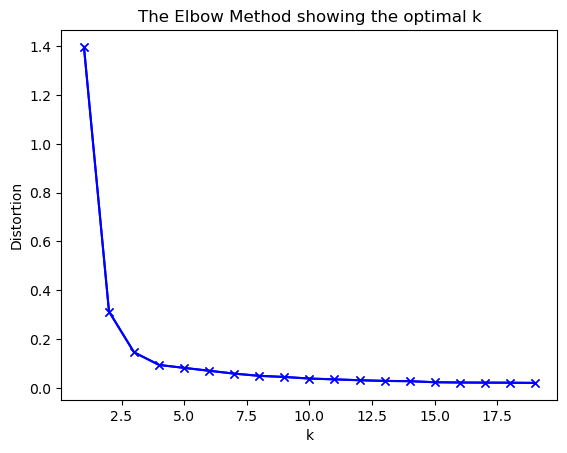

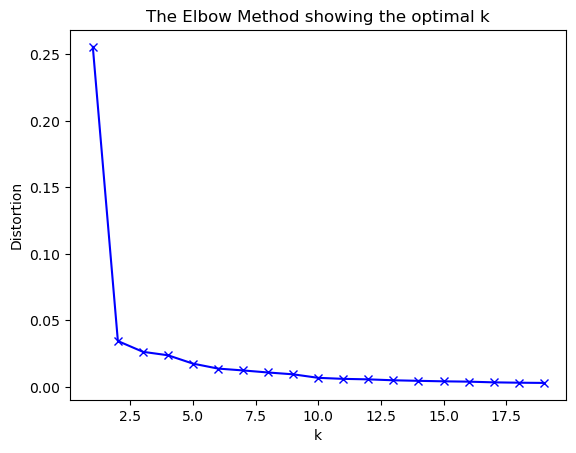

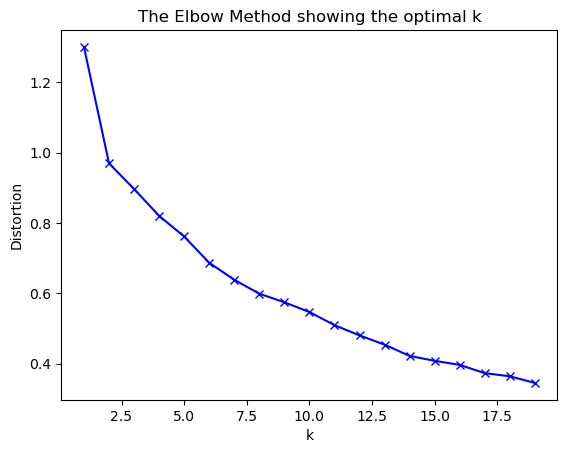

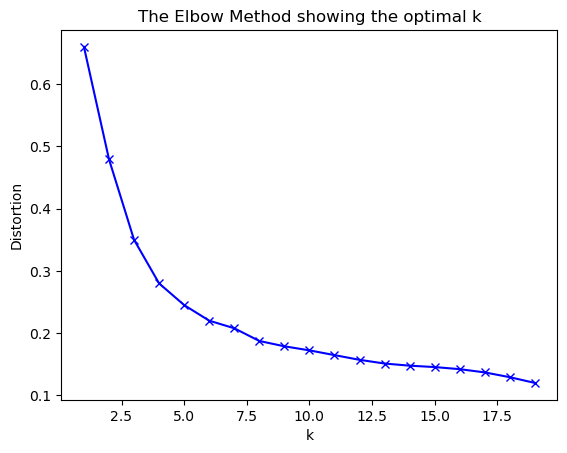

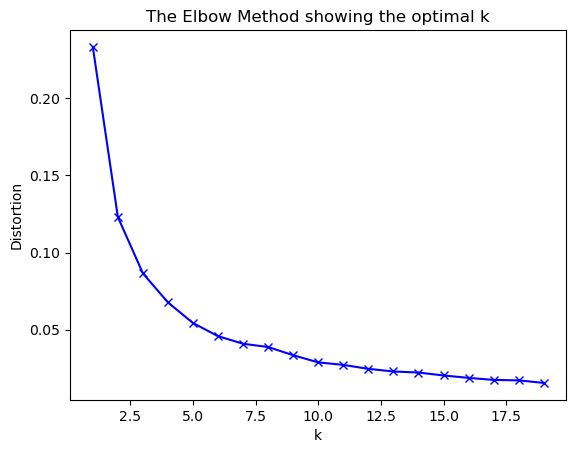

In [46]:
for x in features_class:
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=5).fit(x)
        kmeanModel.fit(x)
        distortions.append(
            sum(
                np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)
            ) / x.shape[0]
        )

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

Grupos

In [54]:
kmeanModel1 = KMeans(n_clusters=10, random_state=5)
kmeanModel1.fit(km_comentario)
df_full['Grupo comentario'] = kmeanModel1.predict(km_comentario)

In [48]:
kmeanModel2 = KMeans(n_clusters=16, random_state=5)
kmeanModel2.fit(km_click)
df_full['Grupo click'] = kmeanModel2.predict(km_click)

In [49]:
kmeanModel3 = KMeans(n_clusters=17, random_state=5)
kmeanModel3.fit(km_coordenadas)
df_full['Grupo coordenadas'] = kmeanModel3.predict(km_coordenadas)

In [50]:
kmeanModel4 = KMeans(n_clusters=18, random_state=5)
kmeanModel4.fit(km_focus)
df_full['Grupo focus'] = kmeanModel4.predict(km_focus)

In [51]:
kmeanModel5 = KMeans(n_clusters=14, random_state=5)
kmeanModel5.fit(km_tiempo)
df_full['Grupo tiempo'] = kmeanModel5.predict(km_tiempo)

In [62]:
group = 3
df_resp[df_full['Grupo comentario'] == group]

,respuesta
0,1.0
3,1.0
6,1.0
7,1.0
10,1.0
...,...
622,1.0
629,1.0
632,1.0
639,1.0


In [64]:
df_full.comentario[df_full['Grupo comentario'] == 3]

0      Correo general orientado a cualquier persona. ...
3                                  Google no envía links
6      el dominio donde se aloja el archivo, no es el...
7      Los dominios no coinciden, el de la página con...
10     Las horas de creación son extrañas y podrían s...
                             ...                        
622                     Su link direcciona a otra página
629    Puede tratarse de phishing por los archivos ad...
632    Ya que me lleva a un link para ver la foto y n...
639    El enlace redirige a driver--google.com, el cu...
643    Correo cualquiera, enlace adjunto inválido / p...
Name: comentario, Length: 212, dtype: object